In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import os
import datetime
import warnings
warnings.filterwarnings("ignore")

#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


In [2]:
# numerical variables
num_atts = ['bedroomcnt','calculatedbathnbr','age','additional_rooms_count',
           'calculatedfinishedsquarefeet','fullbathcnt','garagecarcnt','garagetotalsqft',
            'latitude','longitude','lotsizesquarefeet', 'roomcnt',
           'numberofstories','structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount',
           'N-ValueRatio', 'N-LivingAreaProp', 'N-NonLivingAreaProp','N-ValueProp']

### 2016 data

In [3]:
maindir = "/home/anerdi/Desktop/Zillow"
logerror = pd.read_csv(maindir + "/data/train_2016_v2.csv/train_2016_v2.csv")
logerror['weeknumber'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').isocalendar()[1])
logerror['month'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').month)
logerror['year'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').year)
properties = pd.read_csv(maindir + "/data/properties_2016.csv/properties_2016.csv")

#proportion of living area
properties['N-LivingAreaProp'] = properties['calculatedfinishedsquarefeet']/properties['lotsizesquarefeet']

properties['N-NonLivingAreaProp'] = properties['garagetotalsqft']/properties['lotsizesquarefeet']

#Ratio of the built structure value to land area
properties['N-ValueProp'] = properties['structuretaxvaluedollarcnt']/properties['landtaxvaluedollarcnt']

#Ratio of tax of property over parcel
properties['N-ValueRatio'] = properties['taxvaluedollarcnt']/properties['taxamount']

# Pool
properties['poolsizesum'] = properties['poolsizesum'].fillna(0)
# properties['Pool'] = (properties['poolsizesum'] > 0).astype(int)
properties['Pool'] = (properties['pooltypeid2'].fillna(0) + properties['pooltypeid7'].fillna(0)).astype(int)

properties['regionidcounty'] = properties['regionidcounty'].fillna(9999)
properties['regionidcity'] = properties['regionidcity'].fillna(9999)
properties['regionidneighborhood'] = properties['regionidneighborhood'].fillna(9999)
properties['regionidzip'] = properties['regionidzip'].fillna(9999)
properties['typeconstructiontypeid'] = properties['typeconstructiontypeid'].fillna(9999)
properties['airconditioningtypeid'] = properties['airconditioningtypeid'].fillna(9999)
properties['buildingqualitytypeid'] = properties['buildingqualitytypeid'].fillna(9999)
properties['heatingorsystemtypeid'] = properties['heatingorsystemtypeid'].fillna(9999)
properties['propertylandusetypeid'] = properties['propertylandusetypeid'].fillna(9999)
properties['fips'] = properties['fips'].fillna(9999)

# some more feature engineering
properties['age'] = 2017 - properties['yearbuilt']
properties['additional_rooms_count'] = np.maximum((properties['roomcnt'].values 
                                                   - properties['calculatedbathnbr'].values
                                                   - properties['bedroomcnt'].values),0)

# impute missing num_atts per regionid
for countyid in properties.regionidcounty.unique():
    # setup condition
    cond = properties['regionidcounty'] == countyid
    indices = np.where(cond)[0]
    # impute values based on region
    if countyid != 9999:
        properties.loc[indices,num_atts] = (properties.loc[indices,num_atts]
                                .fillna(properties.loc[indices,num_atts]
                                .apply(np.mean)))
    else:
        properties.loc[indices,num_atts] = (properties.loc[indices,num_atts]
                                            .fillna(properties[num_atts]
                                            .apply(np.mean)))

data2016 = pd.merge(properties,logerror[['parcelid','logerror','month','year']], on='parcelid')
del logerror
del properties

In [4]:
data2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,N-LivingAreaProp,N-NonLivingAreaProp,N-ValueProp,N-ValueRatio,Pool,age,additional_rooms_count,logerror,month,year
0,17073783,9999.0,NaN,NaN,2.5,3.0,NaN,9999.0,2.5,NaN,...,0.728530,0.000000,1.500013,95.188729,0,31.0,0.0,0.0953,1,2016
1,17088994,9999.0,NaN,NaN,1.0,2.0,NaN,9999.0,1.0,NaN,...,0.288494,0.057010,1.500042,92.852051,0,27.0,1.0,0.0198,3,2016
2,17100444,9999.0,NaN,NaN,2.0,3.0,NaN,9999.0,2.0,NaN,...,0.167605,0.067134,2.361880,80.881955,0,61.0,0.0,0.0060,5,2016
3,17102429,9999.0,NaN,NaN,1.5,2.0,NaN,9999.0,1.5,NaN,...,0.210000,0.062162,2.635597,92.143882,0,52.0,1.5,-0.0566,6,2016
4,17109604,9999.0,NaN,NaN,2.5,4.0,NaN,9999.0,2.5,NaN,...,0.381758,0.105122,1.000000,94.106935,0,33.0,1.5,0.0573,8,2016


In [ ]:
data2016.to_csv("/home/anerdi/Desktop/Zillow/data/traindata2016.csv.gz", compression='gzip')

### 2017 data

In [5]:
logerror = pd.read_csv(maindir + "/data/train_2017.csv")
logerror['weeknumber'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').isocalendar()[1])
logerror['month'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').month)
logerror['year'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').year)
properties = pd.read_csv(maindir + "/data/properties_2017.csv")

#proportion of living area
properties['N-LivingAreaProp'] = properties['calculatedfinishedsquarefeet']/properties['lotsizesquarefeet']

properties['N-NonLivingAreaProp'] = properties['garagetotalsqft']/properties['lotsizesquarefeet']

#Ratio of the built structure value to land area
properties['N-ValueProp'] = properties['structuretaxvaluedollarcnt']/properties['landtaxvaluedollarcnt']

#Ratio of tax of property over parcel
properties['N-ValueRatio'] = properties['taxvaluedollarcnt']/properties['taxamount']

# Pool
properties['poolsizesum'] = properties['poolsizesum'].fillna(0)
# properties['Pool'] = (properties['poolsizesum'] > 0).astype(int)
properties['Pool'] = (properties['pooltypeid2'].fillna(0) + properties['pooltypeid7'].fillna(0)).astype(int)

properties['regionidcounty'] = properties['regionidcounty'].fillna(9999)
properties['regionidcity'] = properties['regionidcity'].fillna(9999)
properties['regionidneighborhood'] = properties['regionidneighborhood'].fillna(9999)
properties['regionidzip'] = properties['regionidzip'].fillna(9999)
properties['typeconstructiontypeid'] = properties['typeconstructiontypeid'].fillna(9999)
properties['airconditioningtypeid'] = properties['airconditioningtypeid'].fillna(9999)
properties['buildingqualitytypeid'] = properties['buildingqualitytypeid'].fillna(9999)
properties['heatingorsystemtypeid'] = properties['heatingorsystemtypeid'].fillna(9999)
properties['propertylandusetypeid'] = properties['propertylandusetypeid'].fillna(9999)
properties['fips'] = properties['fips'].fillna(9999)

# some more feature engineering
properties['age'] = 2017 - properties['yearbuilt']
properties['additional_rooms_count'] = np.maximum((properties['roomcnt'].values 
                                                   - properties['calculatedbathnbr'].values
                                                   - properties['bedroomcnt'].values),0)

# impute missing num_atts per regionid
for countyid in properties.regionidcounty.unique():
    # setup condition
    cond = properties['regionidcounty'] == countyid
    indices = np.where(cond)[0]
    # impute values based on region
    if countyid != 9999:
        properties.loc[indices,num_atts] = (properties.loc[indices,num_atts]
                                .fillna(properties.loc[indices,num_atts]
                                .apply(np.mean)))
    else:
        properties.loc[indices,num_atts] = (properties.loc[indices,num_atts]
                                            .fillna(properties[num_atts]
                                            .apply(np.mean)))


data2017 = pd.merge(properties,logerror[['parcelid','logerror','month','year']], on='parcelid')
del logerror
del properties

In [6]:
data2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,N-LivingAreaProp,N-NonLivingAreaProp,N-ValueProp,N-ValueRatio,Pool,age,additional_rooms_count,logerror,month,year
0,17054981,9999.0,NaN,NaN,5.0,4.0,NaN,9999.0,5.0,NaN,...,0.088081,0.018366,1.353190,90.231417,1,35.0,2.0,-0.013099,6,2017
1,17055743,9999.0,NaN,NaN,2.0,3.0,NaN,9999.0,2.0,66.0,...,0.203151,0.000000,0.428562,78.745757,0,66.0,1.0,0.073985,7,2017
2,17068109,9999.0,NaN,NaN,1.5,3.0,NaN,9999.0,1.5,66.0,...,0.656105,0.000000,2.075403,95.939559,0,38.0,1.5,0.071886,7,2017
3,17073952,9999.0,NaN,NaN,2.0,2.0,NaN,9999.0,2.0,NaN,...,0.289306,0.056807,0.536145,95.663356,0,28.0,0.0,0.305680,6,2017
4,17078502,9999.0,NaN,NaN,1.0,2.0,NaN,9999.0,1.0,NaN,...,0.207337,0.110048,0.334893,95.315640,0,69.0,2.0,-0.073787,7,2017


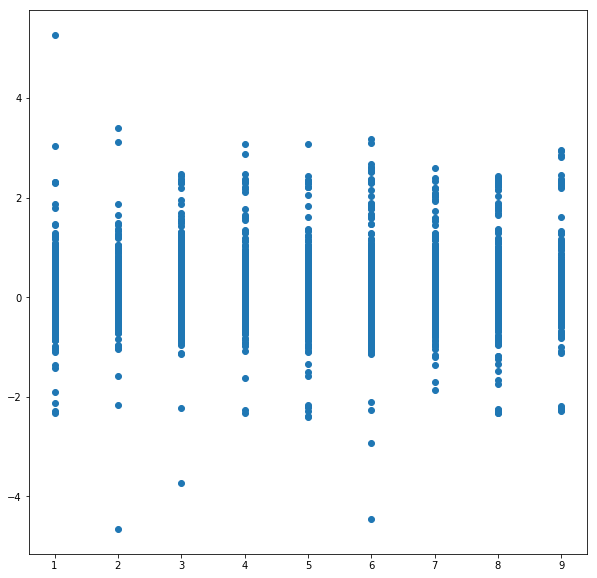

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(data2017['month'],data2017['logerror'])

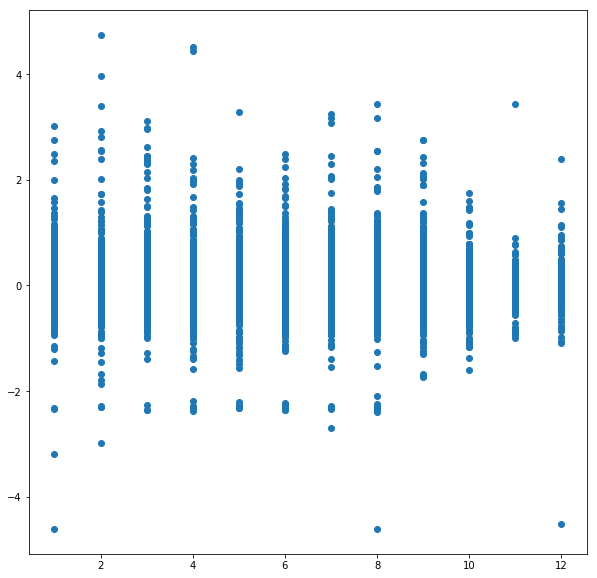

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(data2016['month'],data2016['logerror'])

In [9]:
data2016.columns == data2017.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [11]:
data = data2016.append(data2017)

In [12]:
assert data2016.shape[0] + data2017.shape[0] == data.shape[0]

In [14]:
data.shape

(167888, 68)

In [15]:
data.to_csv("/home/anerdi/Desktop/Zillow/data/traindata20162017.csv.gz", compression='gzip')